## Quantum Network Coding for Quantum Repeater Networks

In [27]:
# Importing necessary libraries
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
from qiskit.circuit import Instruction
from qiskit import transpile
from qiskit_aer import AerSimulator
import numpy as np
from typing import Tuple, List, Dict

In [28]:
# Magic command to correctly show multiple plots
%matplotlib inline

## Basic building blocks for encoding circuit

In [29]:
# Connection algorithm (qubits: Control, Resource, Target)
def con() -> Instruction:
    
    qc = QuantumCircuit(3)
    qc.cx(0,1)
    qc.cx(1,2)
    
    instruction = qc.to_instruction(label=r"Con$^{C}_{R\to T}$")
    
    return instruction

In [30]:
# Connection:Fanout algorithm (qubits: Control, Resource1, Target1, Resource2, Target2)
def fanout() -> Instruction:
    
    qc = QuantumCircuit(5)
    qc.cx(0,1)
    qc.cx(0,3)
    qc.cx(1,2)
    qc.cx(3,4)
    
    instruction = qc.to_instruction(label=r"Fanout$^{C}_{R_1\to T_1,R_2\to T_2}$")
    
    return instruction

In [31]:
# Connection:Add algorithm (qubits: Control1, Control2, Resource, Target)
def add() -> Instruction:
    
    qc = QuantumCircuit(4)
    qc.cx(0,2)
    qc.cx(1,2)
    qc.cx(2,3)
    
    instruction = qc.to_instruction(label=r"Add$^{C_1,C_2}_{R\to T}$")
    
    return instruction

In [32]:
# Removal algorithm (qubits: Resource, Target)
def rem() -> Instruction:
    
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cz(0,1)
    
    instruction = qc.to_instruction(label=r"Rem$_{R\to T}$")
    
    return instruction

In [33]:
# Removal:Add algorithm (qubits: Resource, Target1, Target2)
def remadd() -> Instruction:
    
    qc = QuantumCircuit(3)
    qc.h(2)
    qc.cz(2,1)
    qc.cz(2,0)
    
    instruction = qc.to_instruction(label=r"RemAdd$_{R\to T_1,T_2}$")
    
    return instruction

## Examples for using the basic building blocks

In [34]:
# Connection circuit function
def connection_circuit() -> QuantumCircuit:
    
    # Initialize quantum circuit
    qc = QuantumCircuit(QuantumRegister(1, name='A'),
                        QuantumRegister(1, name='B'),
                        QuantumRegister(1, name='C'),
                        QuantumRegister(1, name='D'))

    # Adding gates to the circuit
    qc.h(0)
    qc.h(2)
    qc.cx(0,1)
    qc.cx(2,3)
    qc.save_statevector(label="init")

    qc.append(con(), [0,2,3])
    qc.save_statevector(label="fin")

    return qc

In [35]:
# Connection:Fanout circuit function
def connection_fanout_circuit() -> QuantumCircuit:

    # Initialize quantum circuit
    qc = QuantumCircuit(QuantumRegister(1, name='A'),
                        QuantumRegister(1, name='B'),
                        QuantumRegister(1, name='C'),
                        QuantumRegister(1, name='D'),
                        QuantumRegister(1, name='E'))

    # Initialize A quantum register to superposition
    alpha = beta = 1/np.sqrt(2)
    qc.initialize([alpha, beta], qc.qregs[0])

    # Adding gates to the circuit
    qc.h(1)
    qc.h(3)
    qc.cx(1,2)
    qc.cx(3,4)
    qc.save_statevector(label="init")
    
    qc.append(fanout(), [0,1,2,3,4])
    qc.save_statevector(label="fin")
    
    return qc

In [36]:
# Connection:Add circuit function
def connection_add_circuit() -> QuantumCircuit:

    # Initialize quantum circuit
    qc = QuantumCircuit(QuantumRegister(1, name='A'),
                        QuantumRegister(1, name='B'),
                        QuantumRegister(1, name='C'),
                        QuantumRegister(1, name='D'))

    # Initialize A and B quantum registers to superposition
    alpha = beta = gamma = delta = 1/np.sqrt(2)
    qc.initialize([alpha, beta], qc.qregs[0])
    qc.initialize([gamma, delta], qc.qregs[1])

    # Adding gates to the circuit
    qc.h(2)
    qc.cx(2,3)
    qc.save_statevector(label="init")

    qc.append(add(), [0,1,2,3])
    qc.save_statevector(label="fin")

    return qc

In [37]:
# Removal circuit function
def removal_circuit() -> QuantumCircuit:

    # Initialize quantum circuit
    qc = QuantumCircuit(QuantumRegister(1, name='A'),
                        QuantumRegister(1, name='B'),
                        QuantumRegister(1, name='C'))

    # Adding gates to the circuit
    qc.h(0)
    qc.cx(0,1)
    qc.cx(0,2)
    qc.save_statevector(label="init")

    qc.append(rem(), [0,1])
    qc.save_statevector(label="fin")

    return qc

In [38]:
# Removal:Add circuit function
def removal_add_circuit() -> QuantumCircuit:

    # Initialize quantum circuit
    qc = QuantumCircuit(QuantumRegister(1, name='A'),
                        QuantumRegister(1, name='B'),
                        QuantumRegister(1, name='C'))

    # Initialize A and B quantum registers to superposition
    alpha = beta = gamma = delta = 1/np.sqrt(2)
    qc.initialize([alpha, beta], qc.qregs[0])
    qc.initialize([gamma, delta], qc.qregs[1])

    # Adding gates to the circuit
    qc.cx(0,2)
    qc.cx(1,2)
    qc.save_statevector(label="init")

    qc.append(remadd(), [0,1,2])
    qc.save_statevector(label="fin")

    return qc

 ## The encoding circuit

In [39]:
# Encoding circuit function
def encoding() -> QuantumCircuit:

    # Initialize quantum circuit
    qc = QuantumCircuit(QuantumRegister(1, name='A'),
                        QuantumRegister(1, name='B'),
                        QuantumRegister(1, name='C'),
                        QuantumRegister(1, name='D'),
                        QuantumRegister(1, name='E'),
                        QuantumRegister(1, name='F'),
                        QuantumRegister(1, name='G'),
                        QuantumRegister(1, name='H'),
                        QuantumRegister(1, name='I'),
                        QuantumRegister(1, name='J'),
                        QuantumRegister(1, name='K'),
                        QuantumRegister(1, name='L'),
                        QuantumRegister(1, name='M'),
                        QuantumRegister(1, name='N'))
    
    # Adding gates to the circuit

    # Input
    qc.h(0)
    qc.h(2)
    qc.h(4)
    qc.h(6)
    qc.h(8)
    qc.h(10)
    qc.h(12)
    qc.cx(0,1)
    qc.cx(2,3)
    qc.cx(4,5)
    qc.cx(6,7)
    qc.cx(8,9)
    qc.cx(10,11)
    qc.cx(12,13)
    #qc.save_statevector(label="input")
    qc.barrier(label="input")

    # Step 1
    qc.append(con(), [0,2,3])
    qc.append(con(), [4,6,7])
    #qc.save_statevector(label="step 1")
    qc.barrier(label="step 1")

    # Step 2
    qc.append(add(), [3,7,8,9])
    #qc.save_statevector(label="step 2")
    qc.barrier(label="step 2")

    # Step 3
    qc.append(fanout(), [9,10,11,12,13])
    #qc.save_statevector(label="step 3")
    qc.barrier(label="step 3")

    # Step 4
    qc.cx(11,1)
    qc.cx(13,5)
    #qc.save_statevector(label="step 4")
    qc.barrier(label="step 4")

    # Step 5
    qc.append(rem(), [11,9])
    qc.append(rem(), [13,9])
    #qc.save_statevector(label="step 5")
    qc.barrier(label="step 5")

    # Step 6
    qc.append(remadd(), [3,7,9])
    #qc.save_statevector(label="step 6")
    qc.barrier(label="step 6")

    # Step 7
    qc.append(rem(), [3,0])
    qc.append(rem(), [7,4])
    qc.save_statevector(label="step 7")

    return qc

## Helper functions for the circuits

In [40]:
# Trace out some qubits from a statevector while keeping others
def trace_out(sv: Statevector, keep_qubit_list: List[int]) -> DensityMatrix:
    
    total_qubits = list(range(14))
    trace_out = [q for q in total_qubits if q not in keep_qubit_list]
    dm = partial_trace(sv, trace_out)
    
    return dm

In [41]:
# Creating Quantum circuit for 2 qubit EPR pair Bell measurement
def bell_measurement(dm: DensityMatrix) -> Tuple[Dict, str]:
    
    qc_bell = QuantumCircuit(2)
    qc_bell.cx(0,1)
    qc_bell.h(0)
    
    dm_bell = dm.evolve(qc_bell)
    probabilities = dm_bell.probabilities_dict()
    likely_result = max(probabilities, key=probabilities.get)
    bell_map = {
        '00': r'|Ψ⁺⟩ = (|00⟩ + |11⟩) / √2',
        '01': r'|Φ⁺⟩ = (|01⟩ + |10⟩) / √2',
        '10': r'|Ψ⁻⟩ = (|00⟩ - |11⟩) / √2',
        '11': r'|Φ⁻⟩ = (|01⟩ - |10⟩) / √2',
    }
    bell_state = bell_map.get(likely_result, 'Unknown')
    
    return probabilities, bell_state

In [42]:
# Helper function to debug entanglement on a whole circuit
def trace_debugger(global_state: Statevector | DensityMatrix, target_qubits: List[int], total_qubits: int) -> None:
    
    if isinstance(global_state, Statevector):
        global_state = DensityMatrix(global_state)

    all_indices = list(range(total_qubits))
    rest_indices = [i for i in all_indices if i not in target_qubits]
    
    reduced_state = partial_trace(global_state, rest_indices)
    rho_squared = reduced_state.data @ reduced_state.data
    full_purity = np.trace(rho_squared.data).real

    print(f"\nPurity of target qubits {target_qubits}: {full_purity:.4f}")
    if np.isclose(full_purity, 1.0):
        print("Target pair is NOT entangled with the rest.")
    else:
        print("Target pair IS entangled with the rest of the system.")

    entangled_with = []
    for i in rest_indices:
        subset = partial_trace(global_state, [j for j in all_indices if j not in target_qubits + [i]])
        purity = np.trace(subset.data @ subset.data).real
        if not np.isclose(purity, 1.0):
            entangled_with.append(i)
            print(f"\tEntangled with qubit {i} (purity: {purity:.4f})")

    if not entangled_with:
        print("No individual qubit is entangled with the pair.")

## Visualizing the circuits of the basic building blocks and checking their validity

<Figure size 1000x600 with 0 Axes>

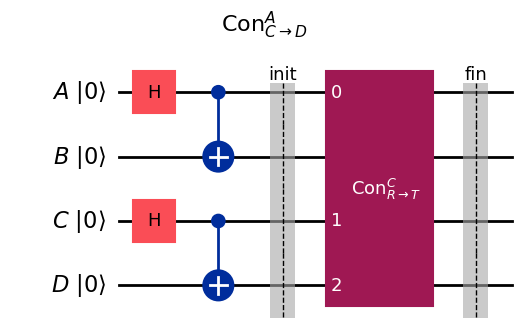

<Figure size 1000x600 with 0 Axes>

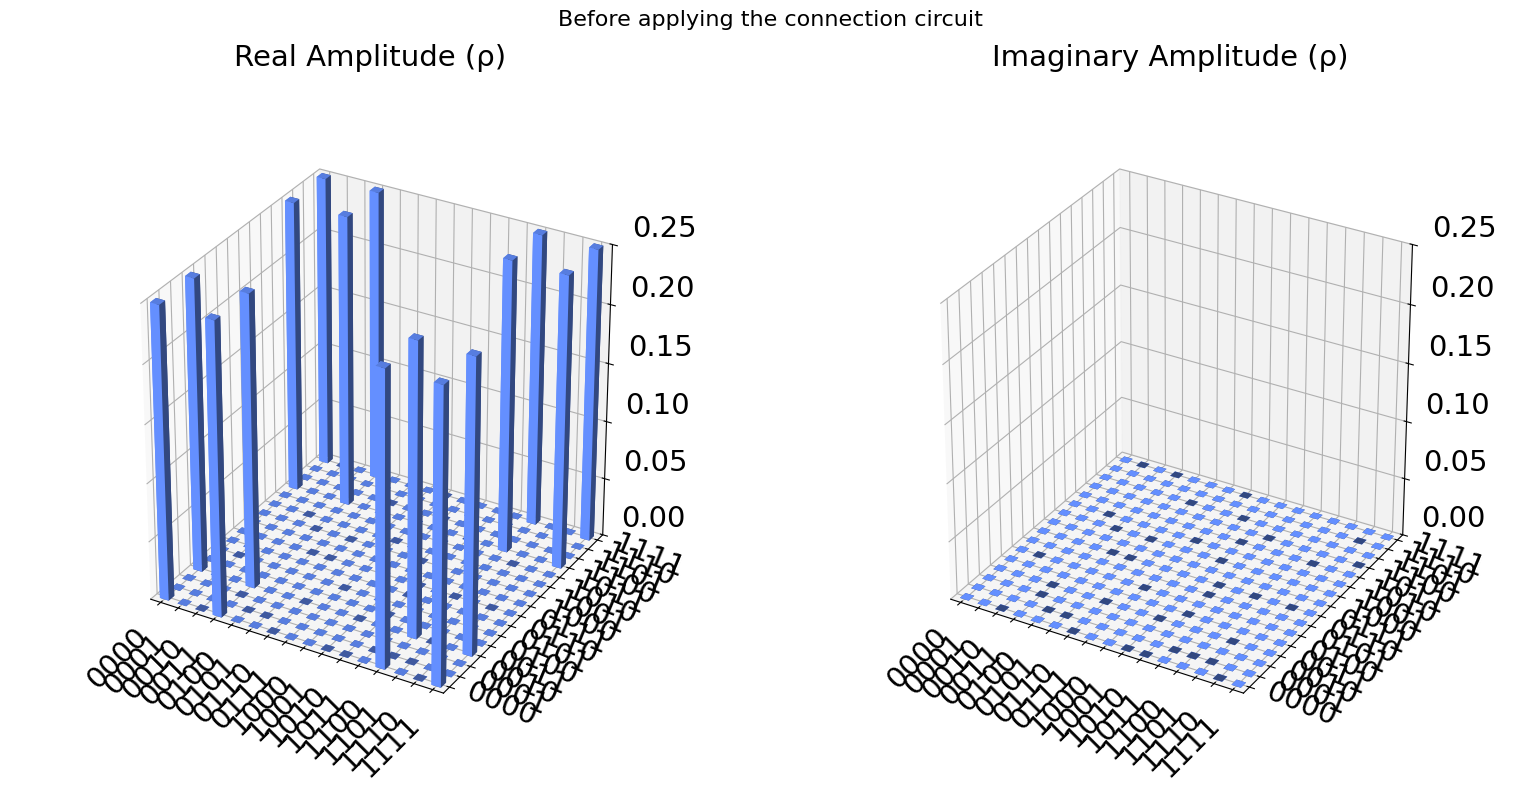

<Figure size 1000x600 with 0 Axes>

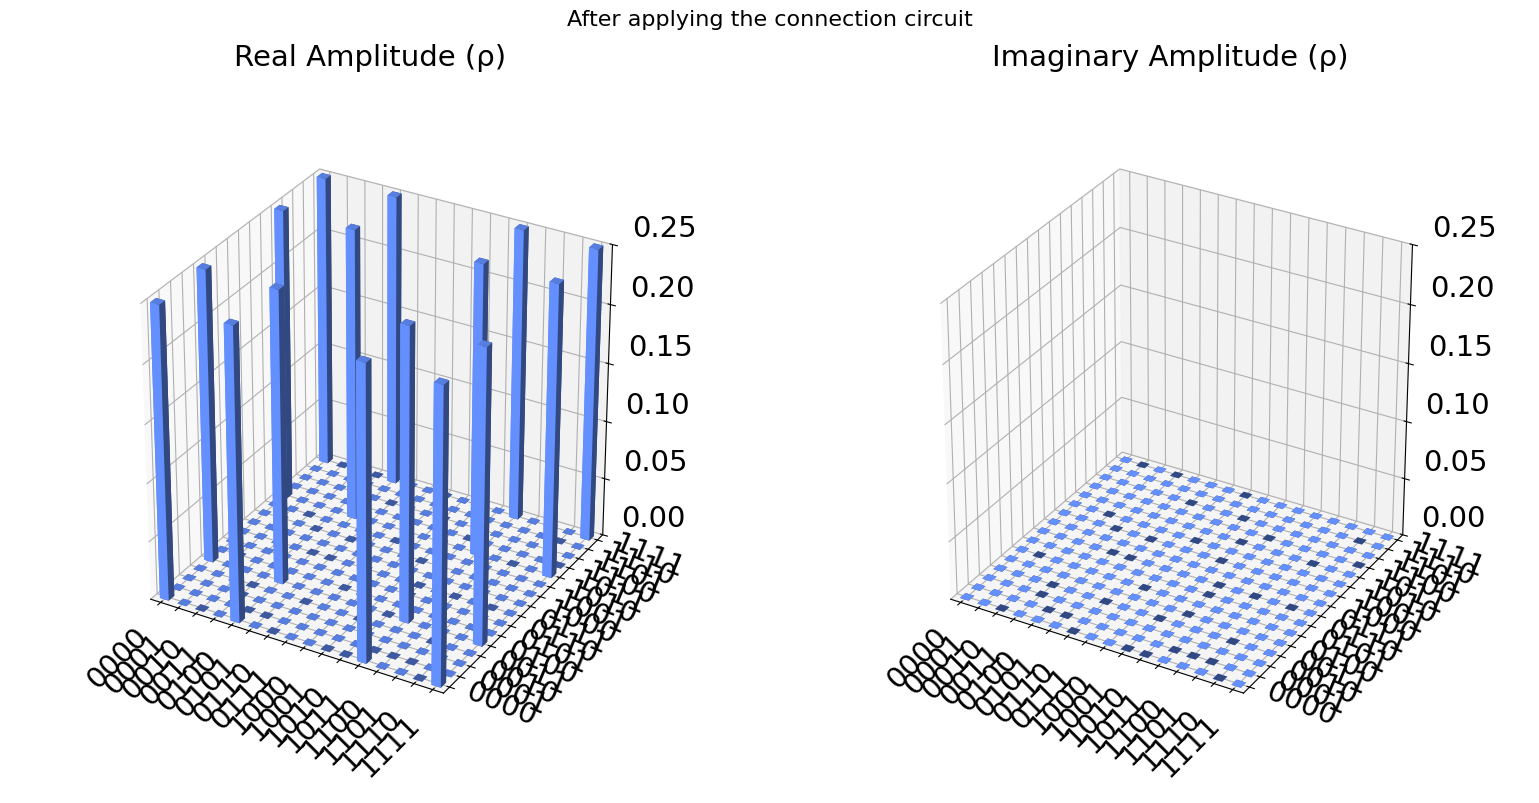

In [43]:
# Connection circuit
qc = connection_circuit()

# Plotting circuit
fig = plt.figure(figsize=(10,6))
qc.draw("mpl", initial_state=True)
plt.title(r"Con$^{A}_{C\to D}$", fontsize=16)
plt.show()

# Creating AER simulation locally
aer_sim = AerSimulator(method='statevector')
tqc = transpile(qc, aer_sim)
result = aer_sim.run(tqc, shots=100).result()
sv_init = result.data()["init"]
sv_fin = result.data()["fin"]

# Plotting initial statevector
fig = plt.figure(figsize=(10,6))
sv_init.draw("city")
plt.suptitle("Before applying the connection circuit", fontsize=16)
plt.show()

# Plotting final statevector
fig = plt.figure(figsize=(10,6))
sv_fin.draw("city")
plt.suptitle("After applying the connection circuit", fontsize=16)
plt.show()

<Figure size 1000x600 with 0 Axes>

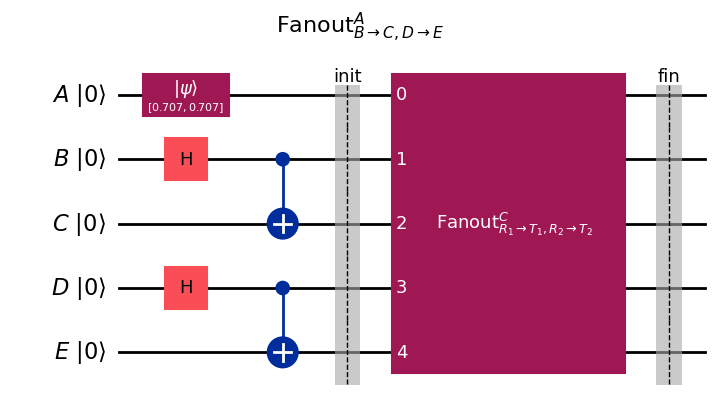

<Figure size 1000x600 with 0 Axes>

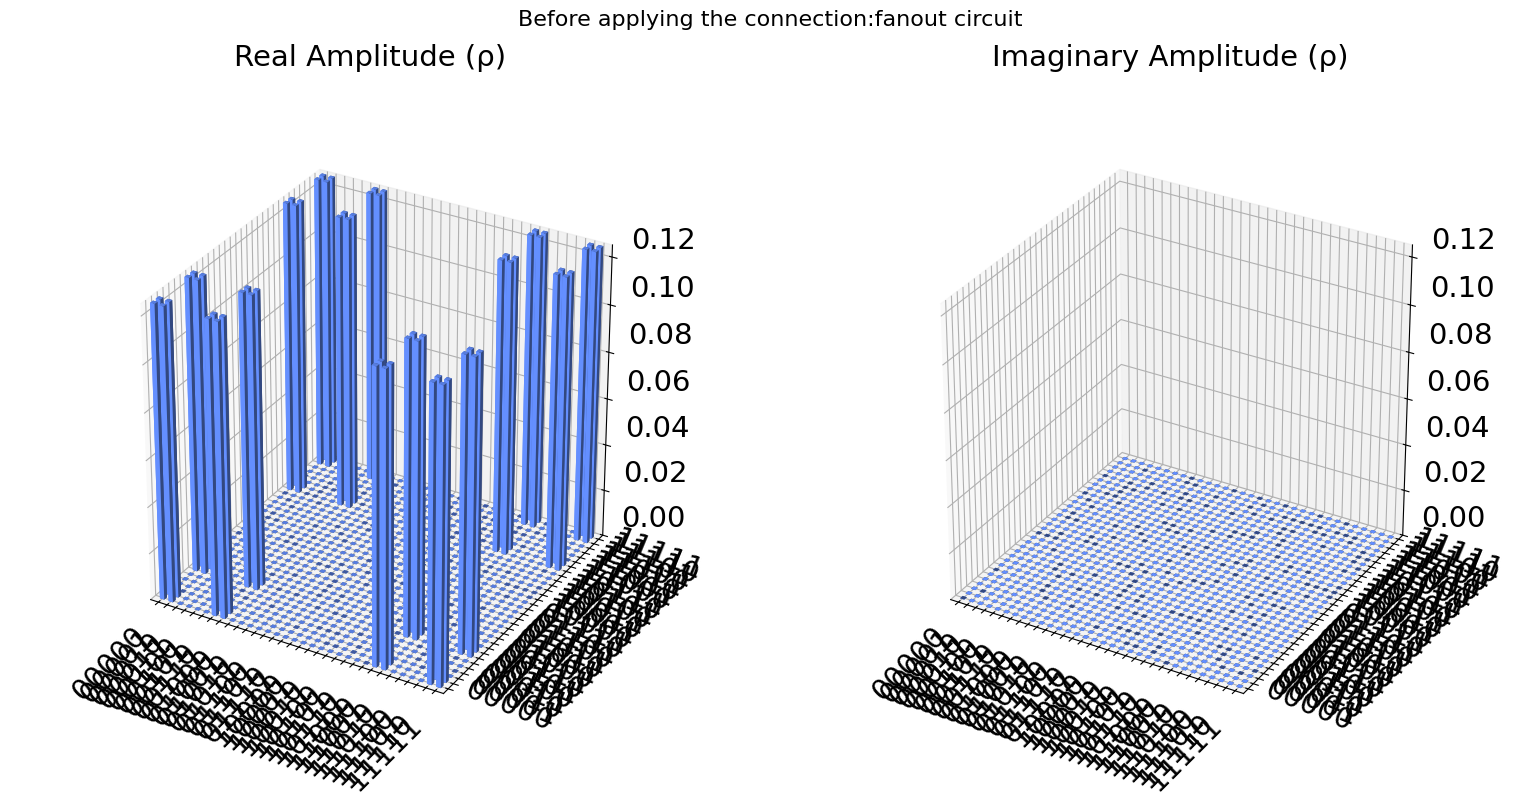

<Figure size 1000x600 with 0 Axes>

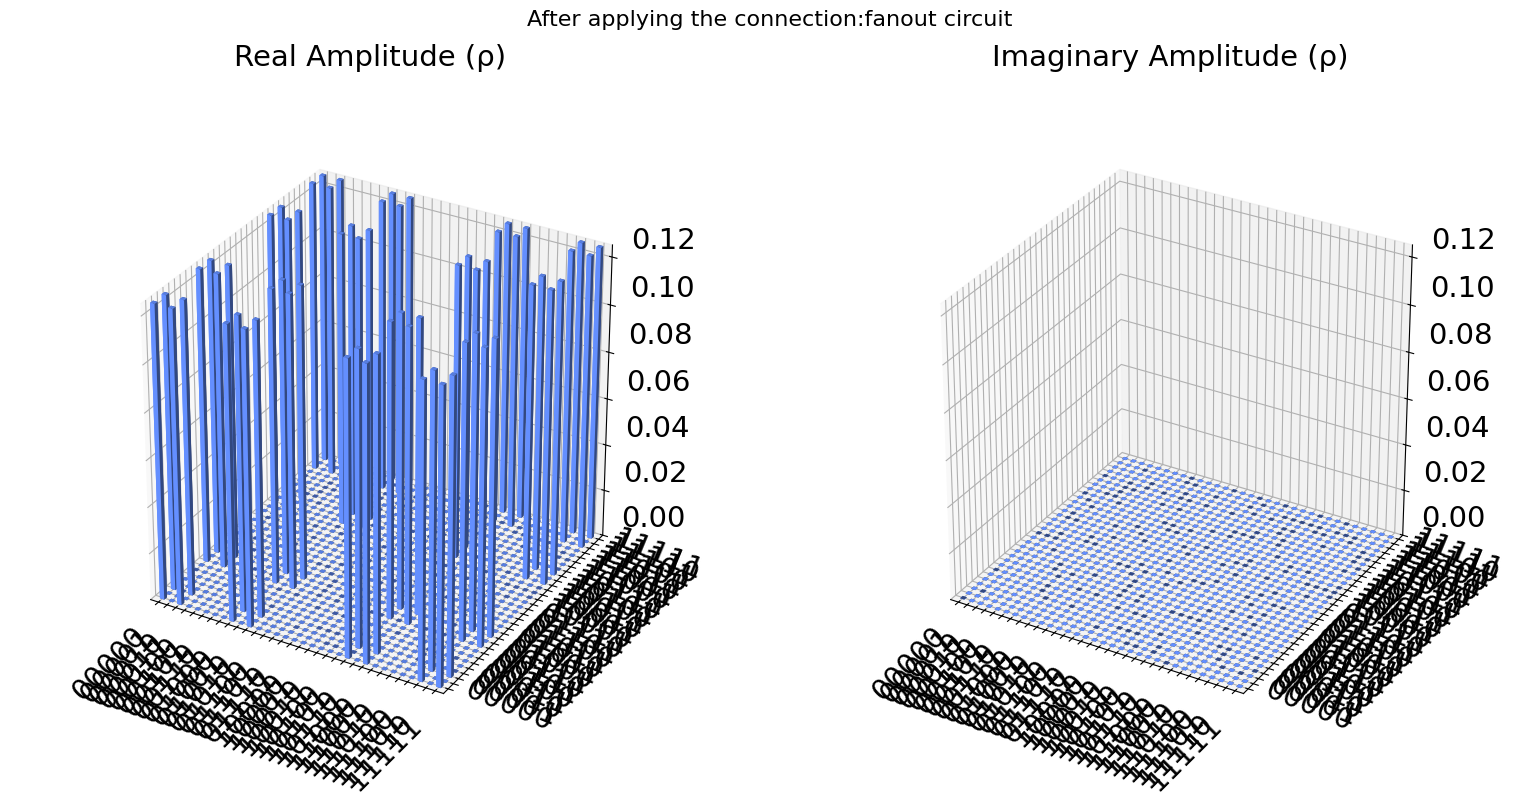

In [44]:
# Connection:Fanout circuit
qc = connection_fanout_circuit()

# Plotting circuit
fig = plt.figure(figsize=(10,6))
qc.draw("mpl", initial_state=True)
plt.title(r"Fanout$^{A}_{B\to C,D\to E}$", fontsize=16)
plt.show()

# Creating AER simulation locally
aer_sim = AerSimulator(method='statevector')
tqc = transpile(qc, aer_sim)
result = aer_sim.run(tqc, shots=100).result()
sv_init = result.data()["init"]
sv_fin = result.data()["fin"]

# Plotting initial statevector
fig = plt.figure(figsize=(10,6))
sv_init.draw("city")
plt.suptitle("Before applying the connection:fanout circuit", fontsize=16)
plt.show()

# Plotting final statevector
fig = plt.figure(figsize=(10,6))
sv_fin.draw("city")
plt.suptitle("After applying the connection:fanout circuit", fontsize=16)
plt.show()

<Figure size 1000x600 with 0 Axes>

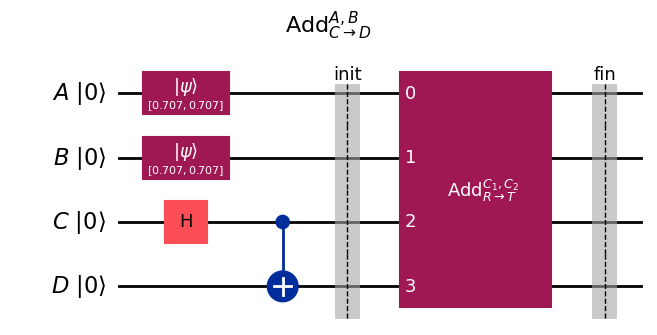

<Figure size 1000x600 with 0 Axes>

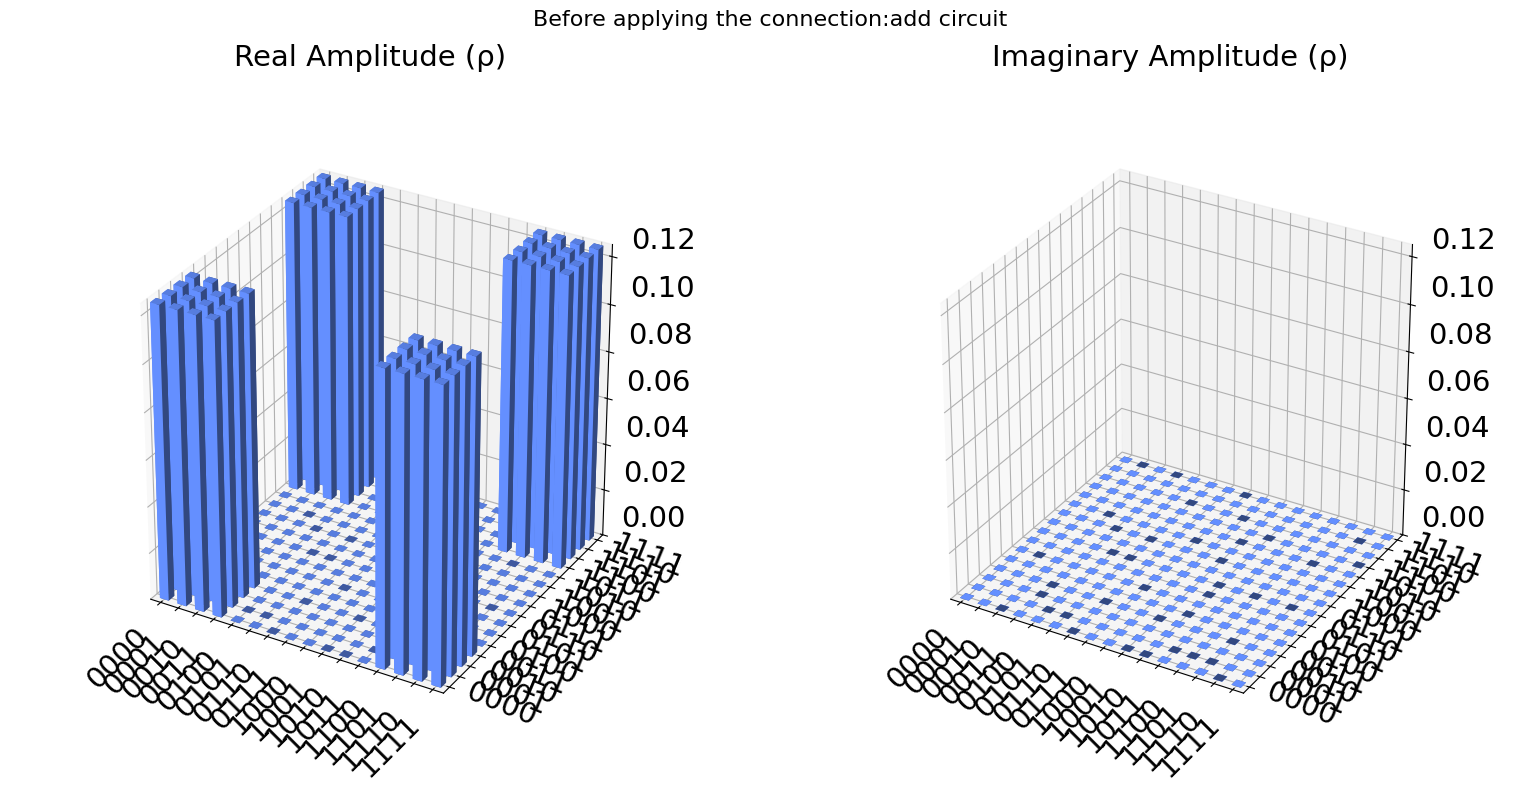

<Figure size 1000x600 with 0 Axes>

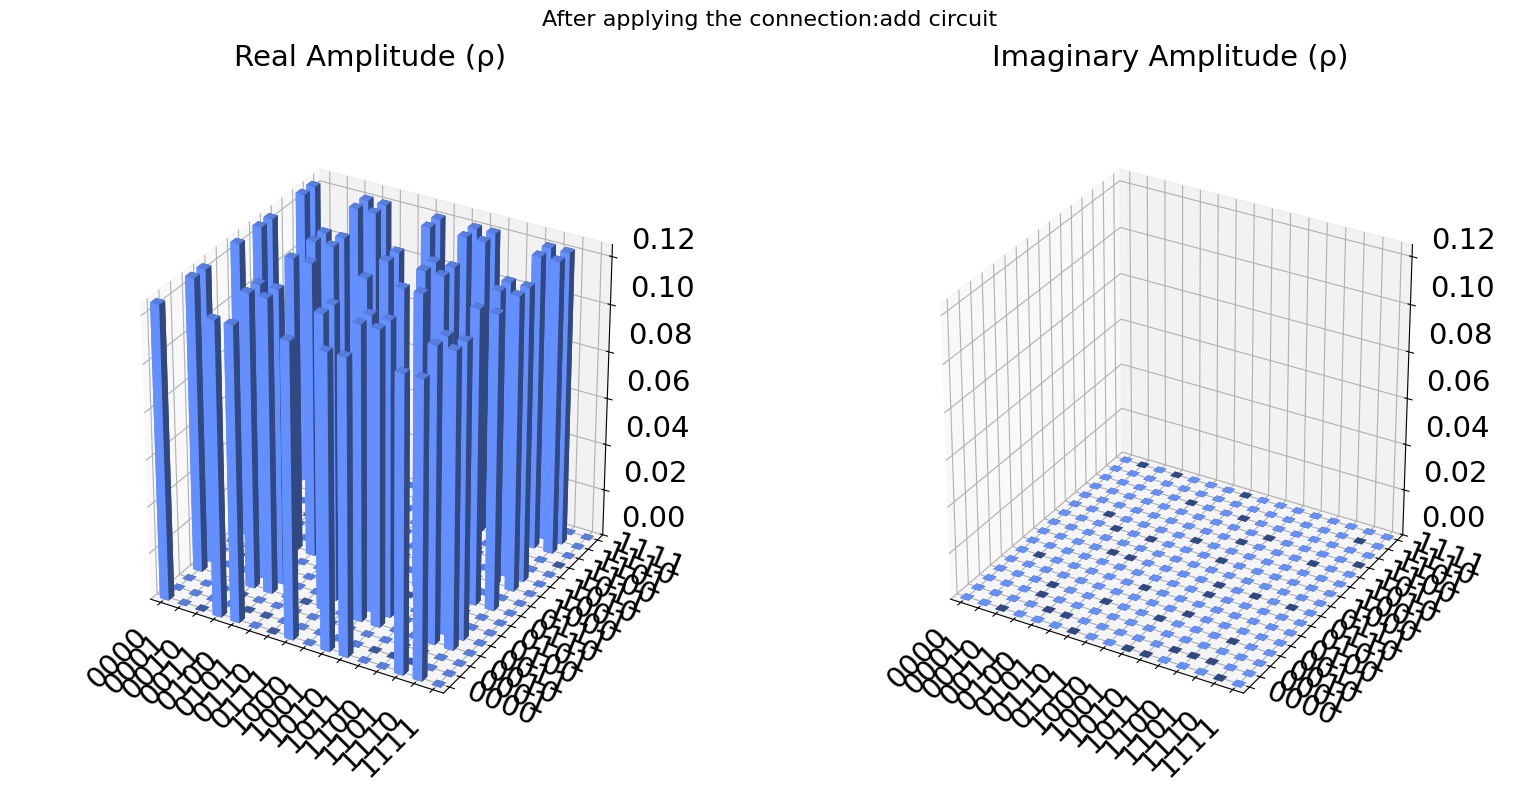

In [45]:
# Connection:Add circuit
qc = connection_add_circuit()

# Plotting circuit
fig = plt.figure(figsize=(10,6))
qc.draw("mpl", initial_state=True)
plt.title(r"Add$^{A,B}_{C\to D}$", fontsize=16)
plt.show()

# Creating AER simulation locally
aer_sim = AerSimulator(method='statevector')
tqc = transpile(qc, aer_sim)
result = aer_sim.run(tqc, shots=100).result()
sv_init = result.data()["init"]
sv_fin = result.data()["fin"]

# Plotting initial statevector
fig = plt.figure(figsize=(10,6))
sv_init.draw("city")
plt.suptitle("Before applying the connection:add circuit", fontsize=16)
plt.show()

# Plotting final statevector
fig = plt.figure(figsize=(10,6))
sv_fin.draw("city")
plt.suptitle("After applying the connection:add circuit", fontsize=16)
plt.show()

<Figure size 1000x600 with 0 Axes>

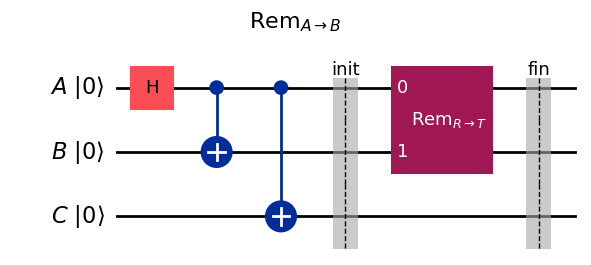

<Figure size 1000x600 with 0 Axes>

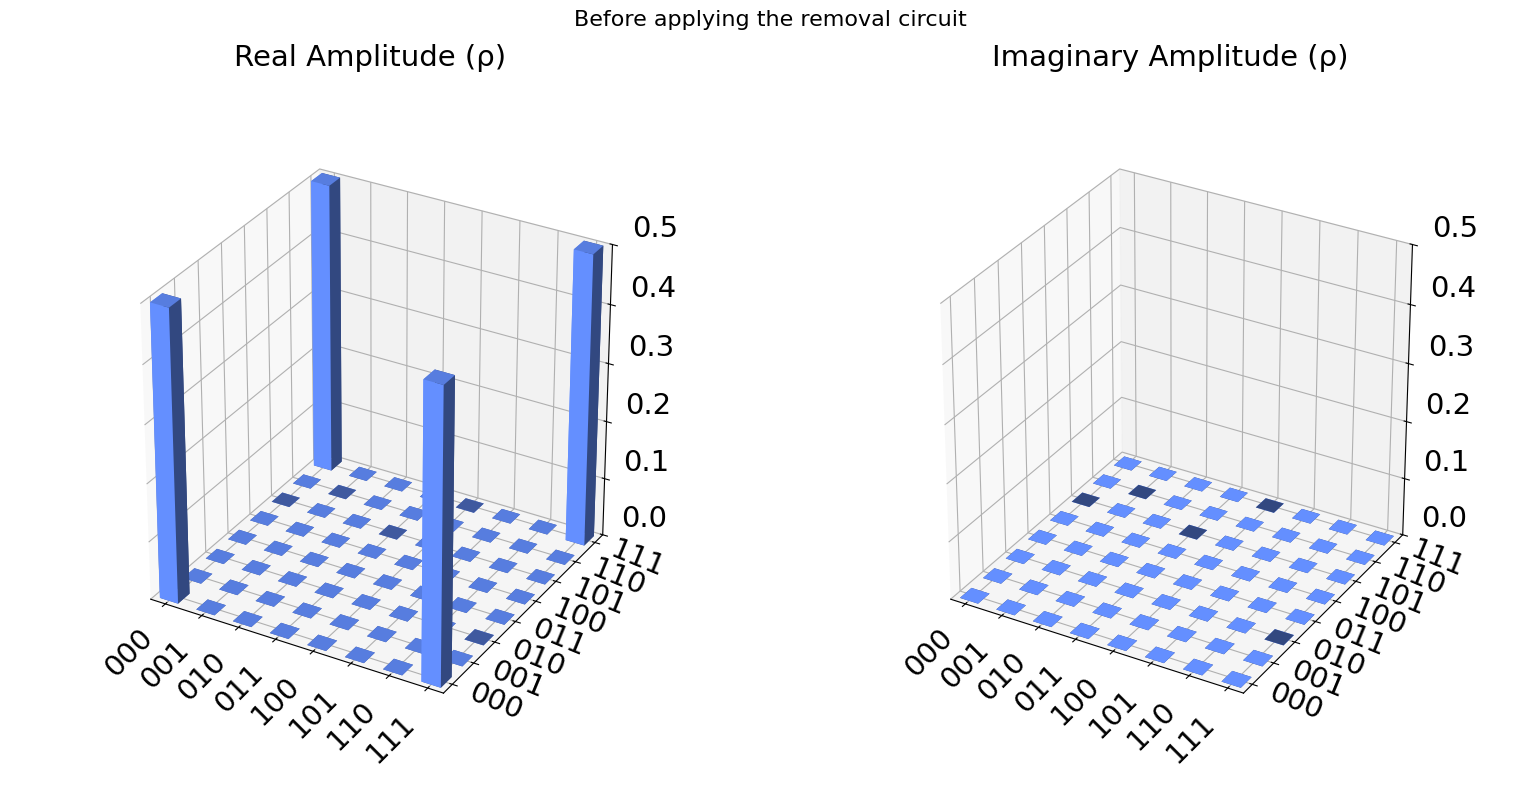

<Figure size 1000x600 with 0 Axes>

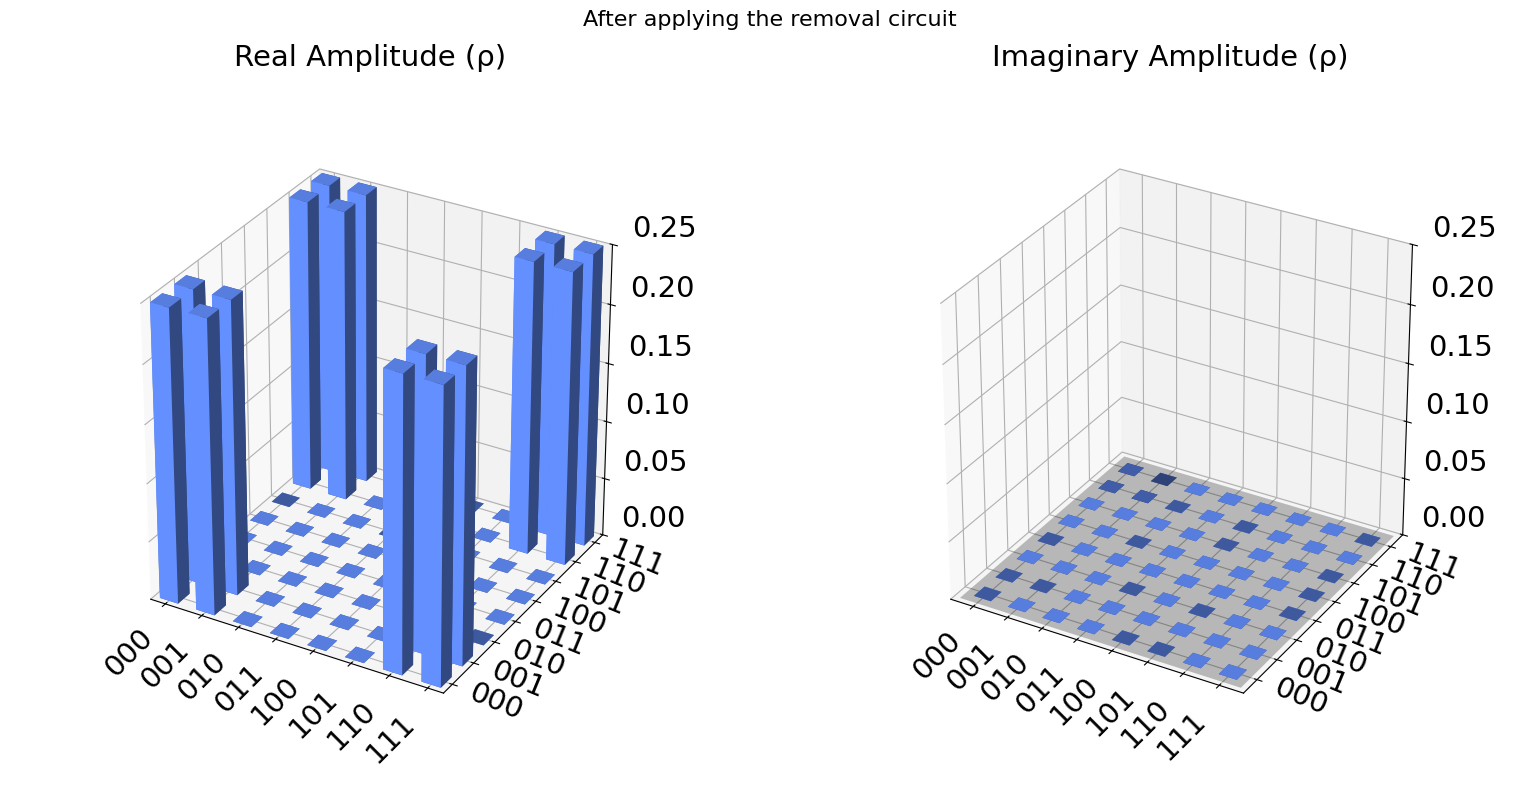

In [46]:
# Removal circuit
qc = removal_circuit()

# Plotting circuit
fig = plt.figure(figsize=(10,6))
qc.draw("mpl", initial_state=True)
plt.title(r"Rem$_{A\to B}$", fontsize=16)
plt.show()

# Creating AER simulation locally
aer_sim = AerSimulator(method='statevector')
tqc = transpile(qc, aer_sim)
result = aer_sim.run(tqc, shots=100).result()
sv_init = result.data()["init"]
sv_fin = result.data()["fin"]

# Plotting initial statevector
fig = plt.figure(figsize=(10,6))
sv_init.draw("city")
plt.suptitle("Before applying the removal circuit", fontsize=16)
plt.show()

# Plotting final statevector
fig = plt.figure(figsize=(10,6))
sv_fin.draw("city")
plt.suptitle("After applying the removal circuit", fontsize=16)
plt.show()

<Figure size 1000x600 with 0 Axes>

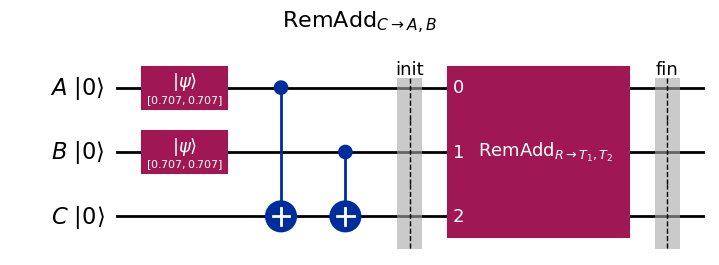

<Figure size 1000x600 with 0 Axes>

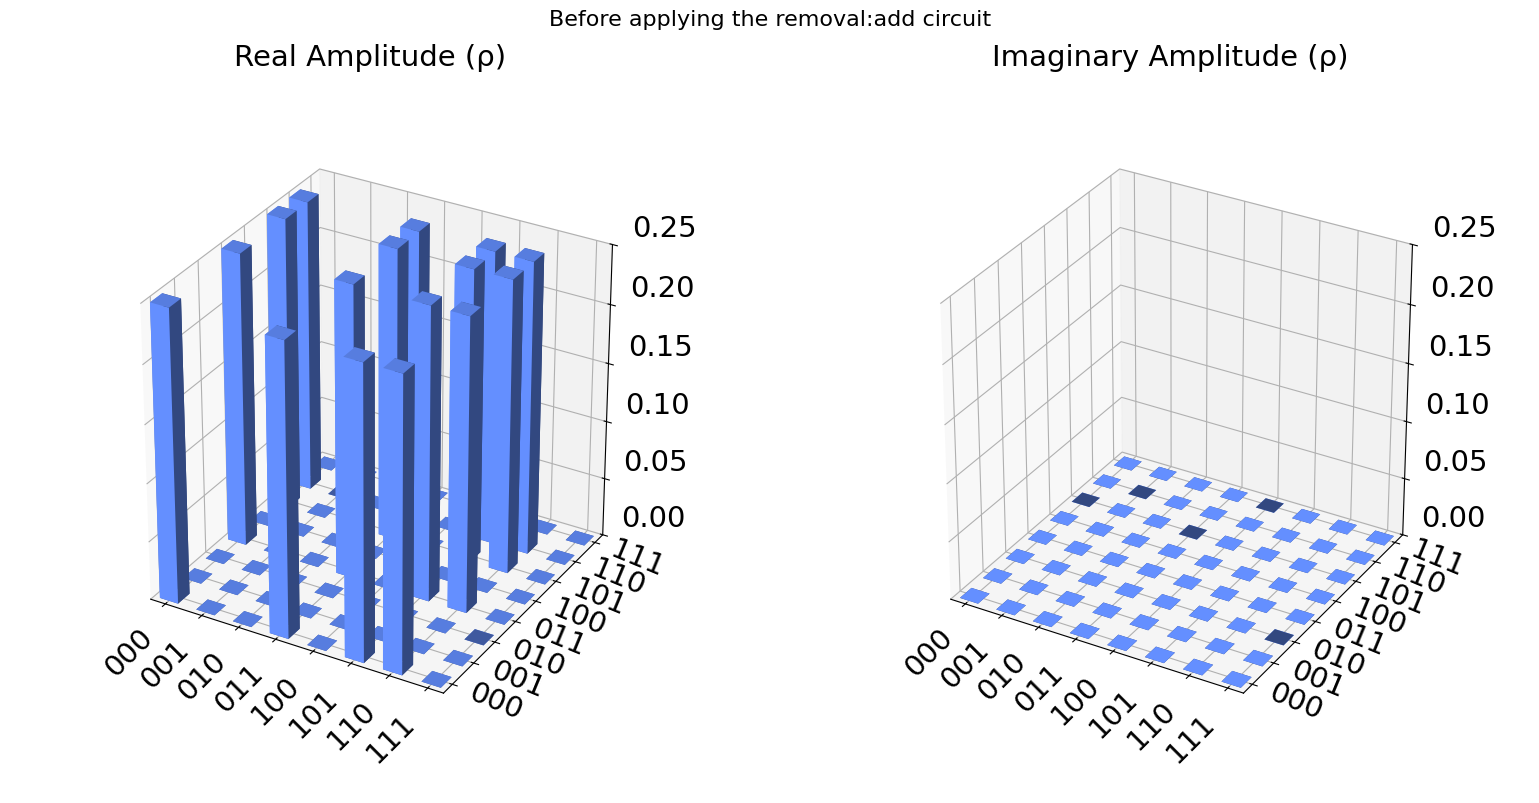

<Figure size 1000x600 with 0 Axes>

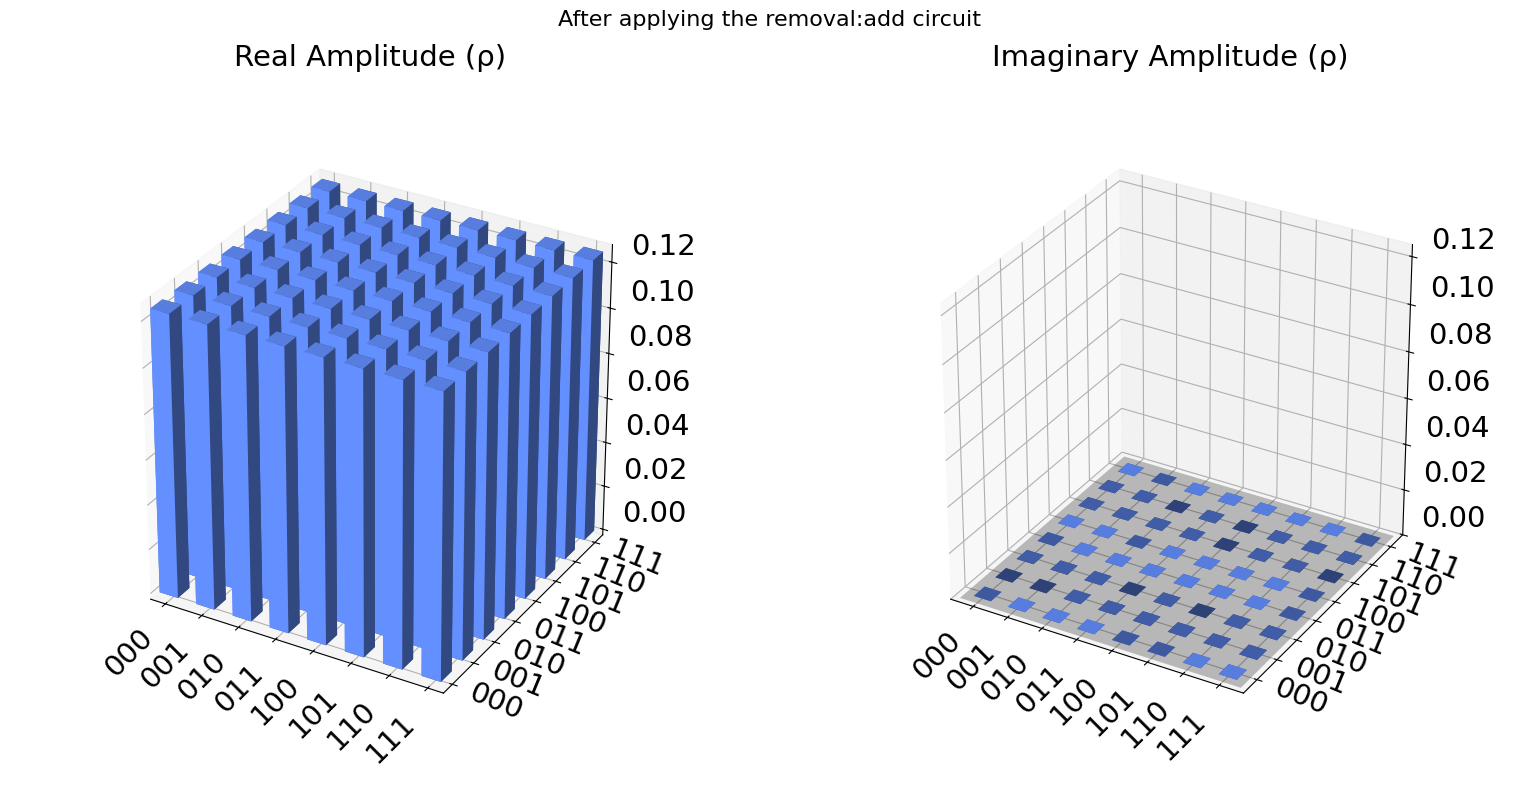

In [47]:
# Removal:Add circuit
qc = removal_add_circuit()

# Plotting circuit
fig = plt.figure(figsize=(10,6))
qc.draw("mpl", initial_state=True)
plt.title(r"RemAdd$_{C\to A,B}$", fontsize=16)
plt.show()

# Creating AER simulation locally
aer_sim = AerSimulator(method='statevector')
tqc = transpile(qc, aer_sim)
result = aer_sim.run(tqc, shots=100).result()
sv_init = result.data()["init"]
sv_fin = result.data()["fin"]

# Plotting initial statevector
fig = plt.figure(figsize=(10,6))
sv_init.draw("city")
plt.suptitle("Before applying the removal:add circuit", fontsize=16)
plt.show()

# Plotting final statevector
fig = plt.figure(figsize=(10,6))
sv_fin.draw("city")
plt.suptitle("After applying the removal:add circuit", fontsize=16)
plt.show()

## Visualizing the circuit of encoding and checking its validity

<Figure size 1000x600 with 0 Axes>

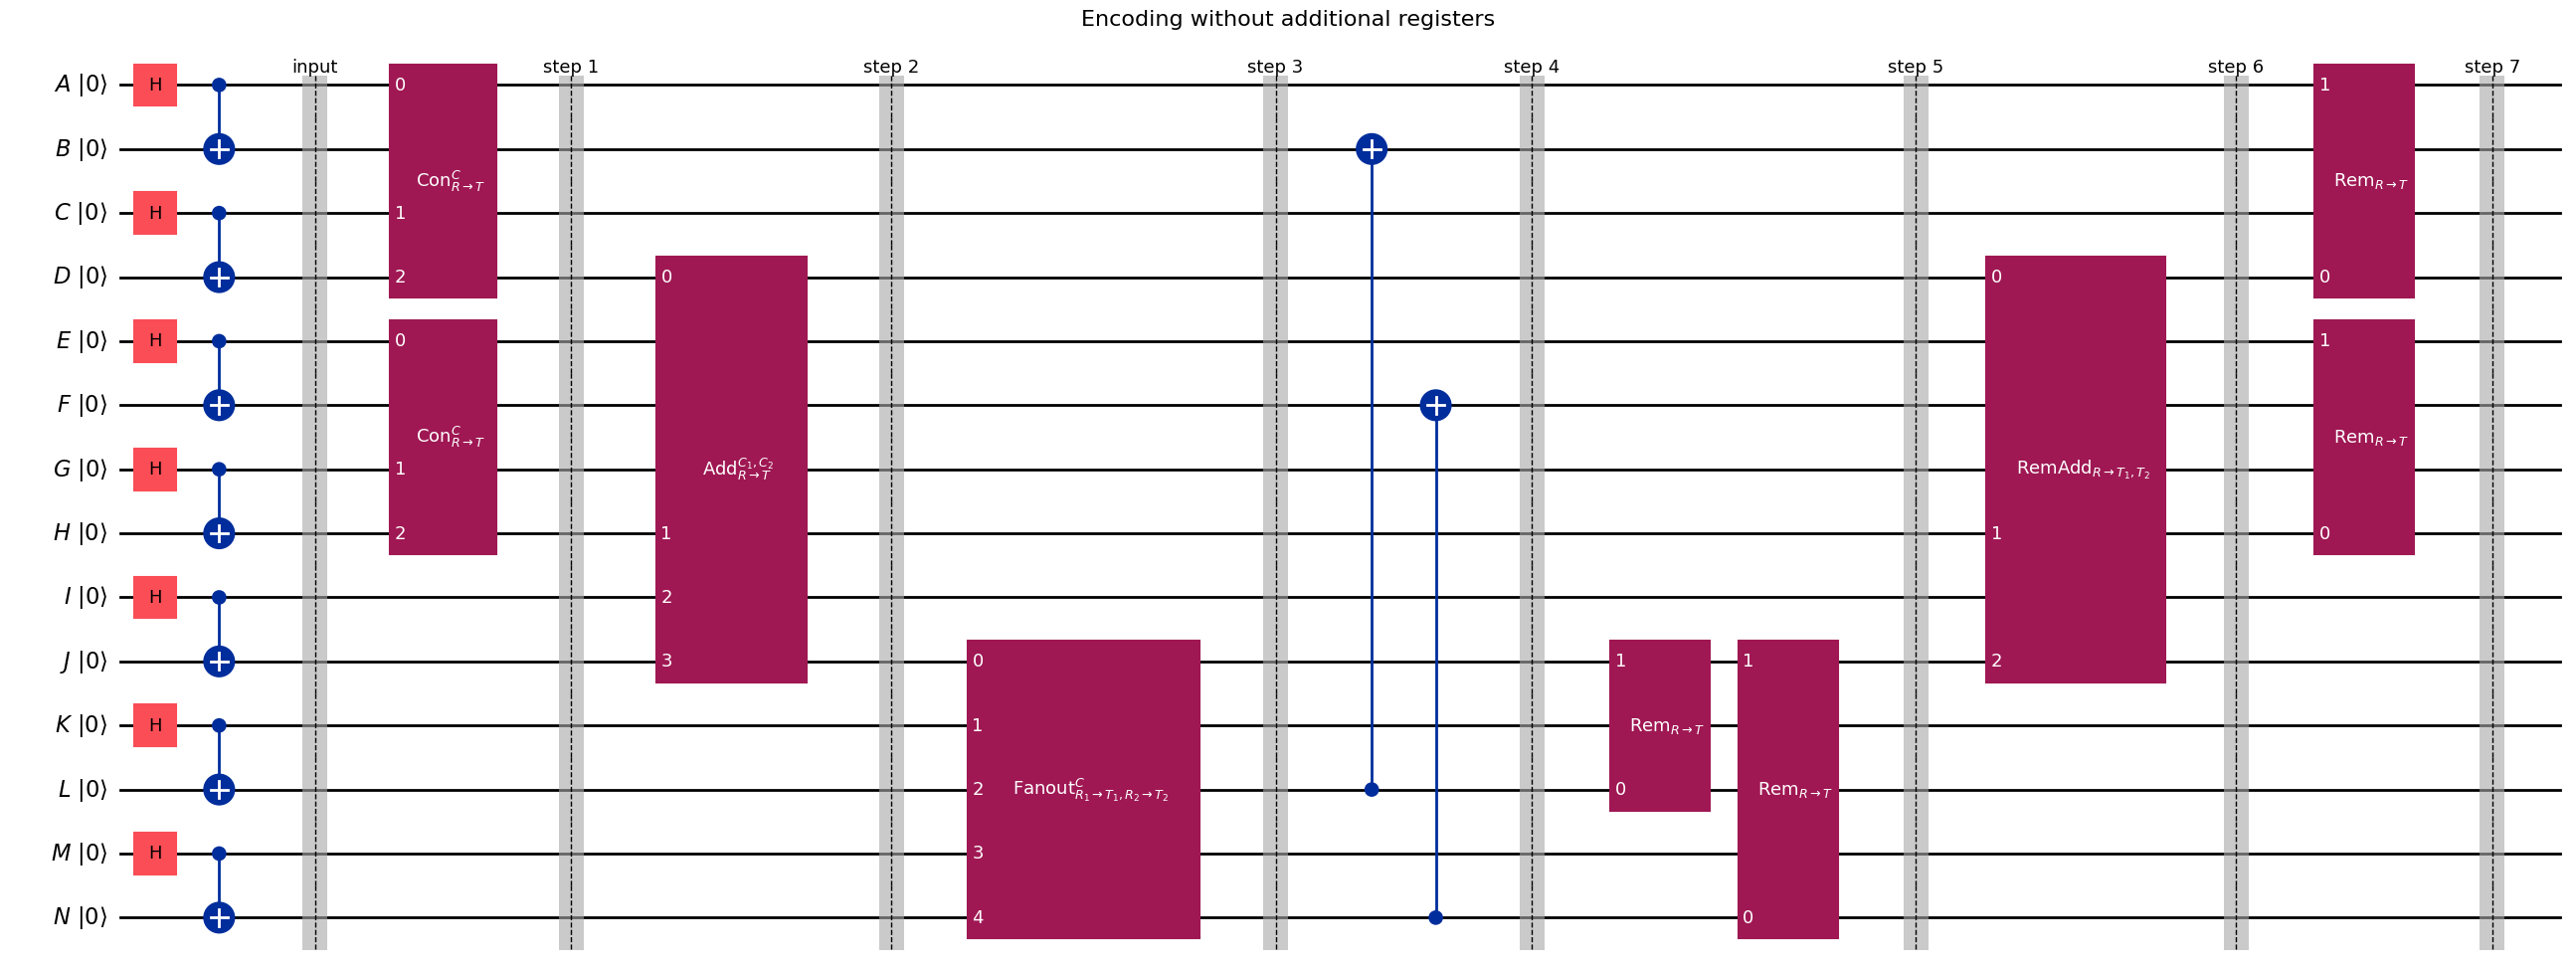

<Figure size 1000x600 with 0 Axes>

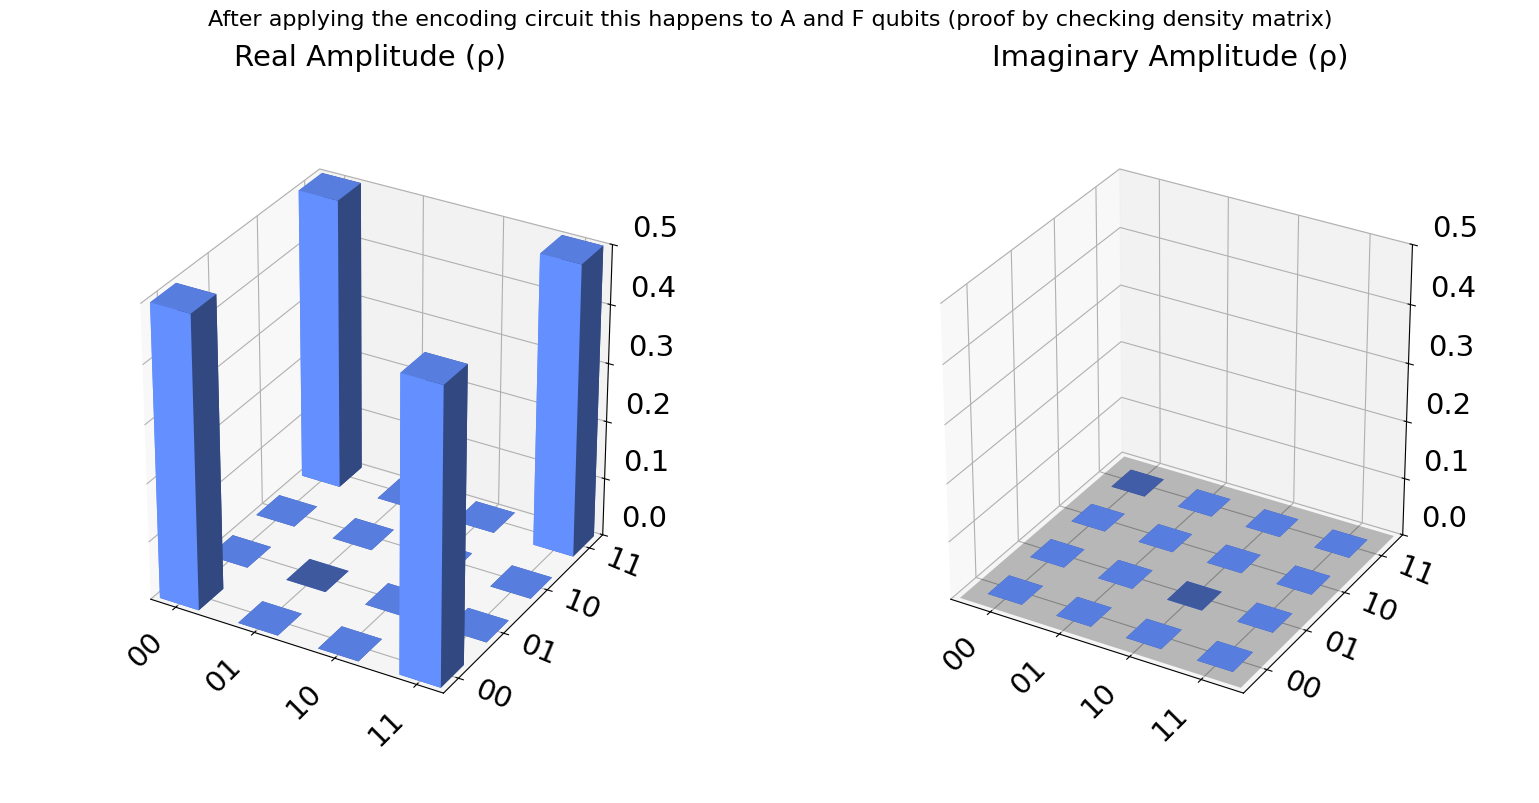

<Figure size 1000x600 with 0 Axes>

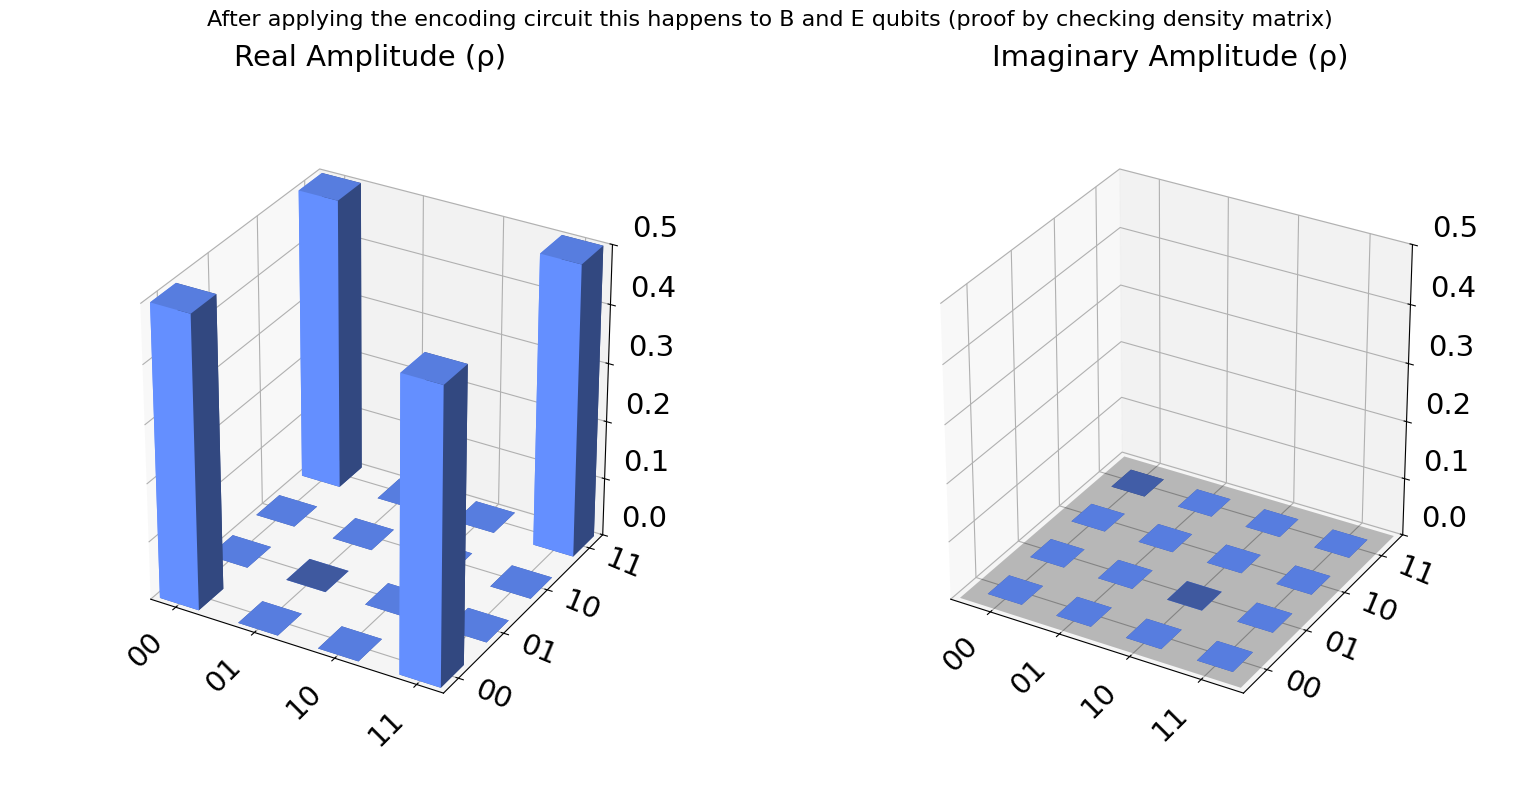

<Figure size 1000x600 with 0 Axes>

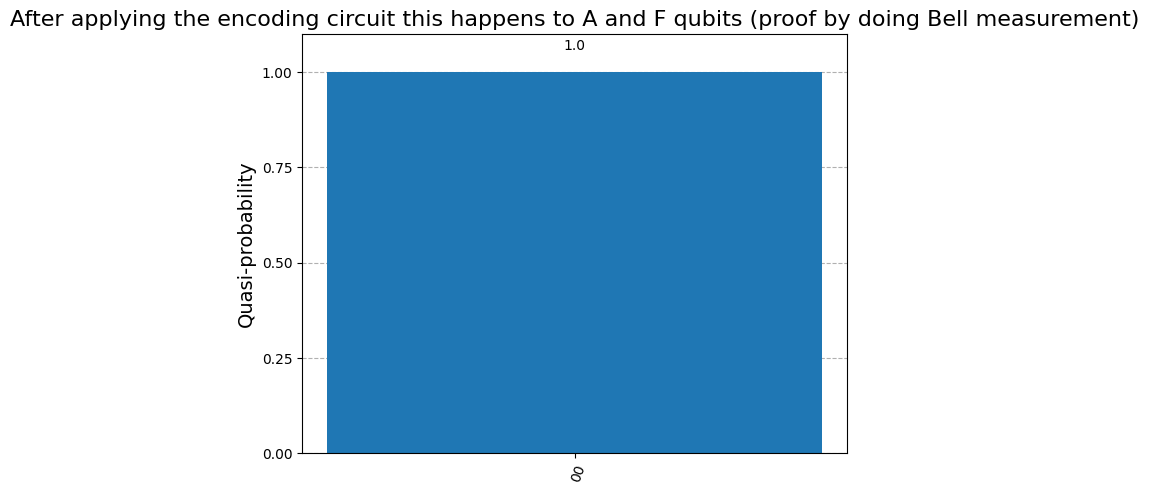

Most likely Bell state: |Ψ⁺⟩ = (|00⟩ + |11⟩) / √2


<Figure size 1000x600 with 0 Axes>

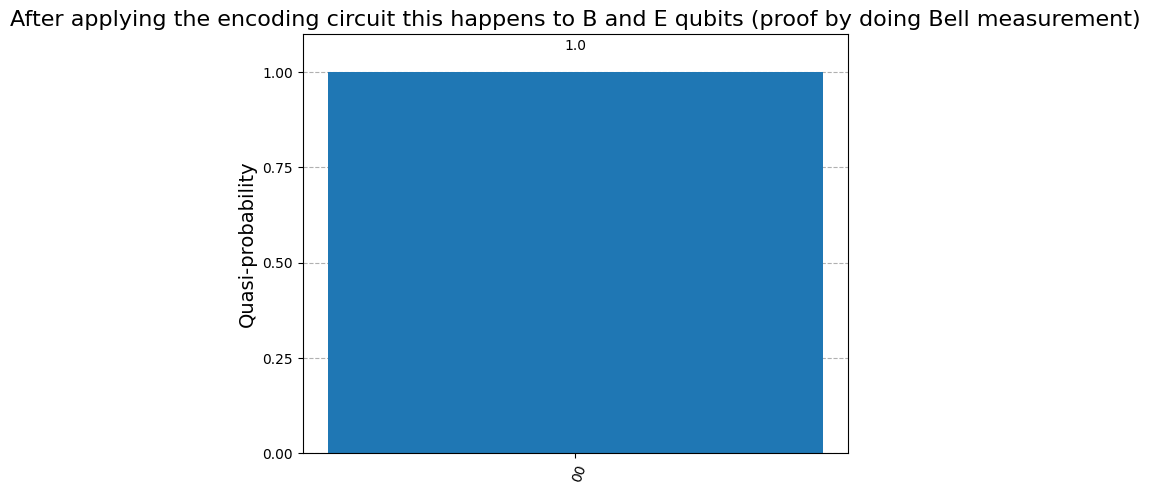

Most likely Bell state: |Ψ⁺⟩ = (|00⟩ + |11⟩) / √2


In [48]:
# Encoding circuit
qc = encoding()

# Plotting circuit
fig = plt.figure(figsize=(10,6))
qc.draw("mpl", initial_state=True, fold=-1)
plt.title("Encoding without additional registers", fontsize=16)
plt.show()

# Creating AER simulation locally
aer_sim = AerSimulator(method='statevector')
tqc = transpile(qc, aer_sim)
result = aer_sim.run(tqc, shots=1000).result()
sv_7 = result.data()["step 7"]

# Trace out qubits except A and F
dm_fin_af = trace_out(sv_7, [0,5])

# Trace out qubits except B and E
dm_fin_be = trace_out(sv_7, [1,4])

# Plotting final density matrix (all qubits traced out except A, F)
fig = plt.figure(figsize=(10,6))
dm_fin_af.draw("city")
plt.suptitle("After applying the encoding circuit this happens to A and F qubits (proof by checking density matrix)", fontsize=16)
plt.show()

# Plotting final density matrix (all qubits traced out except B, E)
fig = plt.figure(figsize=(10,6))
dm_fin_be.draw("city")
plt.suptitle("After applying the encoding circuit this happens to B and E qubits (proof by checking density matrix)", fontsize=16)
plt.show()

# Building circuit for 2 qubit EPR pair Bell measurement (checking A, F qubits)
probabilities_af, state_af = bell_measurement(dm_fin_af)

# Plotting final result to A and F qubits (using Bell measurement)
fig = plt.figure(figsize=(10,6))
plot_histogram(probabilities_af)
plt.title("After applying the encoding circuit this happens to A and F qubits (proof by doing Bell measurement)", fontsize=16)
plt.show()
print(f"Most likely Bell state: {state_af}")

# Building circuit for 2 qubit EPR pair Bell measurement (checking B, E qubits)
probabilities_be, state_be = bell_measurement(dm_fin_be)

# Plotting final result to B and E qubits (using Bell measurement)
fig = plt.figure(figsize=(10,6))
plot_histogram(probabilities_be)
plt.title("After applying the encoding circuit this happens to B and E qubits (proof by doing Bell measurement)", fontsize=16)
plt.show()
print(f"Most likely Bell state: {state_be}")

# Debugging entanglement on the whole circuit
#trace_debugger(sv_7, [0,5], 14)
#trace_debugger(sv_7, [1,4], 14)